In [35]:
%cd/content/drive/My Drive/Đồ án 2 (Sentiment Analysis Vietnamese)

/content/drive/My Drive/Đồ án 2 (Sentiment Analysis Vietnamese)


In [ ]:
!pip install pyvi

     |████████████████████████████████| 8.5MB 3.5MB/s 
     |████████████████████████████████| 747kB 32.2MB/s 


In [ ]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
from pyvi import ViTokenizer
import re
import string
import codecs

In [ ]:
#Từ điển tích cực, tiêu cực, phủ định
path_nag = 'sentiment_dicts/nag.txt'
path_pos = 'sentiment_dicts/pos.txt'
path_not = 'sentiment_dicts/not.txt'

In [ ]:
with codecs.open(path_nag, 'r', encoding='UTF-8') as f:
    nag = f.readlines()
nag_list = [n.replace('\n', '') for n in nag]

with codecs.open(path_pos, 'r', encoding='UTF-8') as f:
    pos = f.readlines()
pos_list = [n.replace('\n', '') for n in pos]
with codecs.open(path_not, 'r', encoding='UTF-8') as f:
    not_ = f.readlines()
not_list = [n.replace('\n', '') for n in not_]


In [ ]:
VN_CHARS_LOWER = u'ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđð'
VN_CHARS_UPPER = u'ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸÐĐ'
VN_CHARS = VN_CHARS_LOWER + VN_CHARS_UPPER

In [ ]:
def no_marks(s):
    __INTAB = [ch for ch in VN_CHARS]
    __OUTTAB = "a"*17 + "o"*17 + "e"*11 + "u"*11 + "i"*5 + "y"*5 + "d"*2
    __OUTTAB += "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 + "Y"*5 + "D"*2
    __r = re.compile("|".join(__INTAB))
    __replaces_dict = dict(zip(__INTAB, __OUTTAB))
    result = __r.sub(lambda m: __replaces_dict[m.group(0)], s)
    return result

In [ ]:
def normalize_text(text):

    #Remove các ký tự kéo dài: vd: đẹppppppp
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    # Chuyển thành chữ thường
    text = text.lower()

    #Chuẩn hóa tiếng Việt, xử lý emoj, chuẩn hóa tiếng Anh, thuật ngữ
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
        "👹": "nagative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "nagative", "😱": "nagative", "😸": "positive",
        "😾": "nagative", "🚫": "nagative",  "🤬": "nagative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
        '👎': ' nagative ', '😣': ' nagative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
        '🤣': ' positive ',"😅": 'positive', '🖤': ' positive ', '🤤': ' positive ', ':(': ' nagative ', '😢': ' nagative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' nagative ', '😊': ' positive ',
        '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' nagative ', '😭': ' nagative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' nagative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' nagative ', '😀': ' positive ', ':((': ' nagative ', '😡': ' nagative ', '😠': ' nagative ',
        '😒': ' nagative ', '🙂': ' positive ', '😏': ' nagative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' nagative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' nagative ', '😓': ' nagative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ',
        '💓': ' positive ', '😐': ' nagative ', ':3': ' positive ', '😫': ' nagative ', '😥': ' nagative ',
        '😃': ' positive ', '😬': 'positive', '😌':'positive', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' nagative ', '😑': ' nagative ', '🔥': ' nagative ', '🙏': ' nagative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' nagative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' nagative ',  '💀': ' nagative ',
        '😔': ' nagative ', '😧': ' nagative ', '😩': ' nagative ', '😰': ' nagative ', '😳': ' nagative ',
        '😵': ' nagative ', '😶': ' nagative ', '🙁': ' nagative ',
        #Chuẩn hóa 1 số sentiment words/English words
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' nagative ',' cc ': ' nagative ','cute': u' dễ thương ','huhu': ' nagative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
        #dưới 3* quy về 1*, trên 3* quy về 5*
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}

    for k, v in replace_list.items():
        text = text.replace(k, v)

    # Loại bỏ dấu câu (Chuyển Puntuation thành space) 
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)

    text = ViTokenizer.tokenize(text)
    texts = text.split()
    len_text = len(texts)

    texts = [t.replace('_', ' ') for t in texts]
    for i in range(len_text):
        cp_text = texts[i]
        if cp_text in not_list: # Xử lý vấn đề phủ định (VD: áo này chẳng đẹp--> áo này notpos)
            numb_word = 2 if len_text - i - 1 >= 4 else len_text - i - 1

            for j in range(numb_word):
                if texts[i + j + 1] in pos_list:
                    texts[i] = 'notpos'
                    texts[i + j + 1] = ''

                if texts[i + j + 1] in nag_list:
                    texts[i] = 'notnag'
                    texts[i + j + 1] = ''
        else: #Thêm feature cho những sentiment words (áo này đẹp--> áo này đẹp positive)
            if cp_text in pos_list:
                texts.append('positive')
            elif cp_text in nag_list:
                texts.append('nagative')

    text = u' '.join(texts)

    #remove nốt những ký tự thừa thãi
    text = text.replace(u'"', u' ')
    text = text.replace(u'️', u'')
    text = text.replace('🏻','')
    return text

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics,naive_bayes
from sklearn import preprocessing
from pyvi import ViTokenizer, ViPosTagger # thư viện NLP tiếng Việt chuyên để tiền xử lí
from gensim.utils import decode_htmlentities
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gensim 
import os
'''
stop_word = []
with open("vnstopword3.txt",encoding="utf-8") as f :
  text = f.read()
  text=text.replace(" ", "_")
  for word in text.split() :
      stop_word.append(word)
  del(word)
  f.close()
'''
import pickle

X_data = pickle.load(open('X_train.pkl', 'rb'))
y_data = pickle.load(open('y_train.pkl', 'rb'))
categorize=['Tích cực', 'Tiêu cực']

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
def BigClassifier(contents):
    input_ = []
    contents = normalize_text(contents)
    input_.append(contents)
    X_data.append(input_[0])
    tfidf_vect = TfidfVectorizer(analyzer='word',max_features=30000)
    tfidf_vect.fit(X_data)

    X_data_tfidf =  tfidf_vect.transform(X_data)

    X_test_tfidf=X_data_tfidf[-1]
    X_data_tfidf=X_data_tfidf[0:22520] 
    feature=tfidf_vect.get_feature_names()
    #encoder = preprocessing.LabelEncoder()
    #y_data_n = encoder.fit_transform(y_data)
    classifier=LogisticRegression()        
    classifier.fit(X_data_tfidf, y_data)
    test_predictions = classifier.predict(X_test_tfidf)[0]

    return (categorize[test_predictions])

In [ ]:
print(BigClassifier("Sản phẩm khong tot cho lắm"))

Tiêu cực


In [ ]:
class DataSource(object):

    def _load_raw_data(self, filename, is_train=True):

        a = []
        b = []

        regex = 'train_'
        if not is_train:
            regex = 'test_'

        with open(filename, 'r') as file:
            for line in file:
                if regex in line:
                    b.append(a)
                    a = [line]
                elif line != '\n':
                    a.append(line)
        b.append(a)

        return b[1:]

    def _create_row(self, sample, is_train=True):

        d = {}
        d['id'] = sample[0].replace('\n', '')
        review = ""

        if is_train:
            for clause in sample[1:-1]:
                review += clause.replace('\n', ' ')
                review = review.replace('.', ' ')

            d['label'] = int(sample[-1].replace('\n', ' '))
        else:
            for clause in sample[1:]:
                review += clause.replace('\n', ' ')
                review = review.replace('.', ' ')


        d['review'] = review

        return d

    def load_data(self, filename, is_train=True):

        raw_data = self._load_raw_data(filename, is_train)
        lst = []

        for row in raw_data:
            lst.append(self._create_row(row, is_train))

        return lst

    def transform_to_dataset(self, x_set,y_set):
        X, y = [], []
        for document, topic in zip(list(x_set), list(y_set)):
            document = normalize_text(document)
            X.append(document.strip())
            y.append(topic)
            #Augmentation bằng cách remove dấu tiếng Việt
            #X.append(no_marks(document))
            #y.append(topic)
        return X, y
    ''' Function only for Word Visualize '''
    def transform_to_testset(self, x_set):
        X = []
        for document in list(x_set):
            document = normalize_text(document)
            X.append(document.strip())
        
        return X

In [ ]:
ds = DataSource()
train_data = pd.DataFrame(ds.load_data('train.crash'))

In [ ]:
print(train_data)

                 id  label                                             review
0      train_000000      0  "Dung dc sp tot cam on  shop Đóng gói sản phẩm...
1      train_000001      0  " Chất lượng sản phẩm tuyệt vời   Son mịn nhưn...
2      train_000002      0  " Chất lượng sản phẩm tuyệt vời nhưng k có hộp...
3      train_000003      1  ":(( Mình hơi thất vọng 1 chút vì mình đã kỳ v...
4      train_000004      1  "Lần trước mình mua áo gió màu hồng rất ok mà ...
...             ...    ...                                                ...
16082  train_016082      1  "Chẳng biết là Shop có biết đọc hay không mua ...
16083  train_016083      1  "Cuốn này mỏng  Đọc một buổi sáng là hết  Thú ...
16084  train_016084      0                              "Mang êm chân  Đẹp " 
16085  train_016085      1  "Tôi đã nhận đc hàng Sau đây là vài lời muốn n...
16086  train_016086      1           "Hình vậy mà túi xấu qá kém chất lg qá" 

[16087 rows x 3 columns]


In [ ]:
test_data = pd.DataFrame(ds.load_data('test.crash', is_train=False))

In [ ]:
print(test_data)

                id                                             review
0      test_000000                     "Chưa dùng thử nên chưa biết" 
1      test_000001  " Không đáng tiềnVì ngay đợt sale nên mới mua ...
2      test_000002  "Cám ơn shop  Đóng gói sản phẩm rất đẹp và chắ...
3      test_000003                   "Vải đẹp phom oki luôn quá ưng" 
4      test_000004                         "Chuẩn hàng đóng gói đẹp" 
...            ...                                                ...
10976  test_010976  " Thời gian giao hàng rất nhanh ngon mà cay qu...
10977  test_010977                                 "Sản phẩm hơi cũ" 
10978  test_010978  "Sản phẩm chắc chắn nhưng k bóng bằng trong hì...
10979  test_010979  " Chất lượng sản phẩm tuyệt vời có mùi thơm rấ...
10980  test_010980                      "như quảng cáo  sim rất tốt" 

[10981 rows x 2 columns]


In [ ]:
''' For Word Visualize '''
X_train, y_train = train_data.review, train_data.label
X_train, y_train = ds.transform_to_dataset(X_train, y_train)
X_test = test_data.review
X_test = ds.transform_to_testset(X_test)
''' For Model '''
#X_train, X_test, y_train, y_test = train_test_split(train_data.review, train_data.label, test_size=0.3,random_state=42)
#X_train, y_train = ds.transform_to_dataset(X_train,y_train)
#X_test, y_test = ds.transform_to_dataset(X_test, y_test)

' For Model '

In [ ]:
X_train

NameError: ignored

In [ ]:
import pickle

pickle.dump(X_train, open('/content/drive/My Drive/Đồ án 2 (Sentiment Analysis Vietnamese)/X_train.pkl', 'wb'))
pickle.dump(y_train, open('/content/drive/My Drive/Đồ án 2 (Sentiment Analysis Vietnamese)/y_train.pkl', 'wb'))
pickle.dump(X_test, open('/content/drive/My Drive/Đồ án 2 (Sentiment Analysis Vietnamese)/X_test.pkl', 'wb'))
pickle.dump(y_test, open('/content/drive/My Drive/Đồ án 2 (Sentiment Analysis Vietnamese)/y_test.pkl', 'wb'))

In [2]:
import pickle
X_train = pickle.load(open('/content/drive/My Drive/Đồ án 2 (Sentiment Analysis Vietnamese)/X_train.pkl', 'rb'))
y_train = pickle.load(open('/content/drive/My Drive/Đồ án 2 (Sentiment Analysis Vietnamese)/y_train.pkl', 'rb'))
X_test = pickle.load(open('/content/drive/My Drive/Đồ án 2 (Sentiment Analysis Vietnamese)/X_test.pkl', 'rb'))
y_test = pickle.load(open('/content/drive/My Drive/Đồ án 2 (Sentiment Analysis Vietnamese)/y_test.pkl', 'rb'))

In [ ]:
X_train[22519]

'nhieu mo den notpos '

In [ ]:
%cd/content/drive/My Drive/Word Embedding

/content/drive/My Drive/Word Embedding


In [ ]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load('./word2vec.model')
vocab = w2v.wv.vocab
wv = w2v.wv

def get_word2vec_data(X):
    word2vec_data = []
    for x in X:
        sentence = []
        for word in x.split(" "):
            if word in vocab:
                sentence.append(wv[word])

        word2vec_data.append(sentence)

    return word2vec_data

X_train_w2v = get_word2vec_data(X_train)
X_test_w2v = get_word2vec_data(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [ ]:
print(X_train_w2v)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)

# transform the training and validation data using count vectorizer object
X_train_counter = count_vect.transform(X_train)
X_test_counter = count_vect.transform(X_test)

In [5]:
X_train_counter

<22520x7772 sparse matrix of type '<class 'numpy.int64'>'
	with 426398 stored elements in Compressed Sparse Row format>

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# word level - we choose max number of words equal to 30000 except all words (100k+ words)
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_train) # learn vocabulary and idf from training set
X_data_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)

In [4]:
X_data_tfidf[22519]

<1x7708 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [5]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_data_tfidf)


X_data_tfidf_svd = svd.transform(X_data_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

In [6]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
y_data_n = encoder.fit_transform(y_train)
y_test_n = encoder.fit_transform(y_test)

encoder.classes_

array([0, 1])

In [7]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

def train_model(classifier, X_data, y_data, X_test, y_test, is_neuralnet=False, n_epochs=200):
  if is_neuralnet:
    classifier.fit(X_data,y_data,validation_data=(X_test,y_test),epochs=n_epochs,batch_size=512)
    train_predictions = classifier.predict(X_train)
    test_predictions = classifier.predict(X_test)       
  else:  
    classifier.fit(X_data, y_data)
    train_predictions = classifier.predict(X_data)
    test_predictions = classifier.predict(X_test)

    print("Test F1 score: ", classification_report(test_predictions, y_test))
#    print("Train accuracy: ", metrics.accuracy_score(train_predictions, y_train))    
#    print("Validation accuracy: ", metrics.accuracy_score(val_predictions, y_val))
#    print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
model = LogisticRegression()
model.fit(X_train_counter, y_train)
y_predict = model.predict(X_test_counter)

NameError: ignored

In [8]:
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
model = SVC(kernel='linear',C=0.7)
model.fit(X_data_tfidf, y_train)
y_predict = model.predict(X_test_tfidf)

In [9]:
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test, y_predict)
print(cm)

[[4936  646]
 [ 305 3767]]


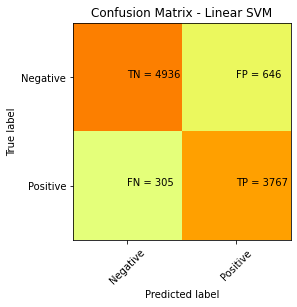

In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Linear SVM')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score
model = MultinomialNB()
model.fit(X_data_tfidf, y_train)
y_predict = model.predict(X_data_tfidf)
res = accuracy_score(y_predict,y_train)
print(res)

0.8866341030195382


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
result_val_linear = []
c = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for i in c:
  model = SVC(kernel = 'linear' , C = i)
  model.fit(X_data_tfidf, y_train)
  y_predict = model.predict(X_test_tfidf)
  result_val_linear.append(accuracy_score(y_predict,y_test))

In [12]:
result_val_linear

[0.8941371452247773,
 0.8968303293971411,
 0.8993163455562461,
 0.9005593536357986,
 0.9007665216490574,
 0.9013880256888337,
 0.901491609695463,
 0.9004557696291693,
 0.9004557696291693,
 0.8995235135695049]

In [13]:
result_train_linear = [0.9060834813499112,
                      0.9119449378330373,
                      0.9167406749555951,
                      0.9212255772646536,
                      0.9238898756660746,
                      0.9259325044404974,
                      0.9278419182948491,
                      0.9296181172291297,
                      0.9313499111900533,
                      0.9323268206039076]
result_val_linear = [0.8941371452247773,
 0.8968303293971411,
 0.8993163455562461,
 0.9005593536357986,
 0.9007665216490574,
 0.9013880256888337,
 0.901491609695463,
 0.9004557696291693,
 0.9004557696291693,
 0.8995235135695049]

In [41]:
result_val_rbf = [0.9009736896623162,
              0.9020095297286099,
              0.9007665216490574,
              0.8996270975761342,
              0.8997306815827636,
              0.8995235135695049,
              0.8994199295628755,
              0.8994199295628755,
              0.8997306815827636,
              0.8999378495960224]
result_train_rbf = [0.96949378330373,
 0.9908081705150977,
 0.9961367673179397,
 0.9974245115452931,
 0.9979573712255773,
 0.9981793960923624,
 0.9983126110124334,
 0.9984014209591474,
 0.9985346358792184,
 0.9986234458259325]

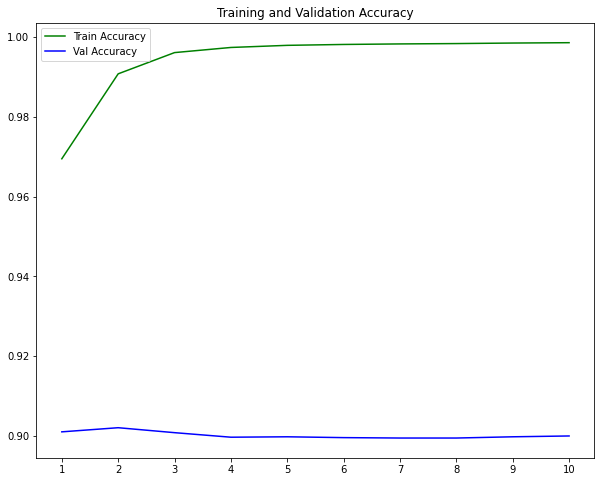

In [57]:
import matplotlib.pyplot as plt
#Plot the Graph
# Loss Curves
plt.figure(figsize=[10,8])
epochs = [1,2,3,4,5,6,7,8,9,10]
plt.plot(epochs, result_train, 'g', label='Train Accuracy')
plt.plot(epochs, result_val, 'b', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
#plt.xlim(0.5,10.5)
plt.xticks(epochs)
plt.legend()
plt.show()
  

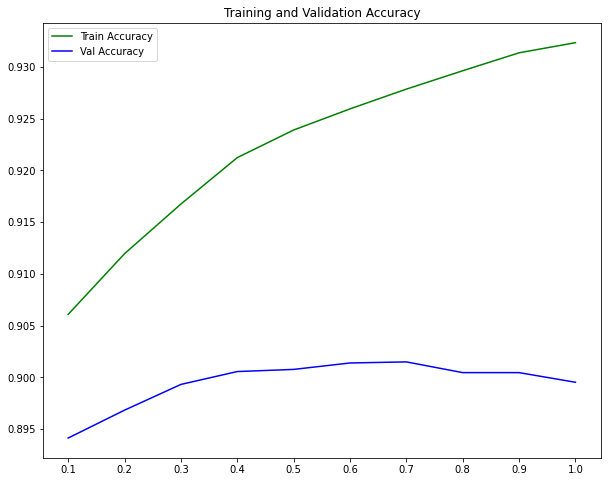

In [14]:
import matplotlib.pyplot as plt
#Plot the Graph
# Loss Curves
plt.figure(figsize=[10,8])
epochs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.plot(epochs, result_train_linear, 'g', label='Train Accuracy')
plt.plot(epochs, result_val_linear, 'b', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
#plt.xlim(0.5,10.5)
plt.xticks(epochs)
plt.legend()
plt.show()
  

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent
from keras.callbacks import Callback
from tensorflow.keras.layers import InputLayer
from keras.layers import LSTM
from keras.callbacks import Callback
import tensorflow as tf
def create_lstm_model():
  model = Sequential()
  model.add(keras.layers.InputLayer(input_shape=(300,)))
  model.add(tf.keras.layers.Reshape((2, 150)))
  model.add(tf.keras.layers.LSTM(120,activation ='relu',return_sequences=True))
  model.add(tf.keras.layers.LSTM(512,activation = 'relu',return_sequences=True))
  model.add(tf.keras.layers.LSTM(512, activation = 'relu',return_sequences=True))
  model.add(tf.keras.layers.LSTM(128, activation = 'relu',return_sequences=True))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(2,activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  print(model.summary())
  return model


In [10]:
LSTM_model = create_lstm_model()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(LSTM_model, to_file=dot_img_file, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 2, 150)            0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 2, 120)            130080    
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 2, 512)            1296384   
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 2, 512)            2099200   
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 2, 128)            328192    
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 256)               0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 2)                 5

AssertionError: ignored

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 2, 150)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 2, 120)            130080    
_________________________________________________________________
lstm_23 (LSTM)               (None, 2, 512)            1296384   
_________________________________________________________________
lstm_24 (LSTM)               (None, 2, 512)            2099200   
_________________________________________________________________
lstm_25 (LSTM)               (None, 2, 128)            328192    
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0   

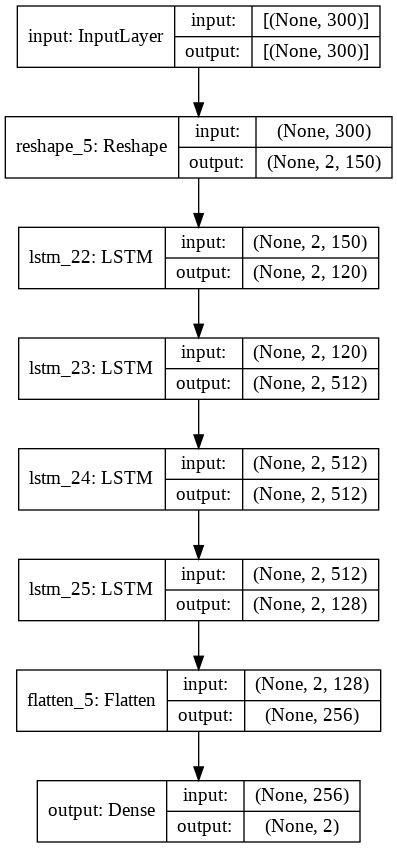

In [30]:
def create_model():
  input = tf.keras.Input(shape=(300,), dtype='float32', name='input')
  #x = tf.keras.layers.Reshape((2,150), input)
  #x = tf.keras.layers.Embedding(
  #    output_dim=512, 
  #    input_dim=1000, 
  #    input_length=50)(input)
  x = tf.keras.layers.Reshape((2,150))(input)
  x = tf.keras.layers.LSTM(120, activation='relu',return_sequences=True)(x)
  x = tf.keras.layers.LSTM(512, activation='relu',return_sequences=True)(x)
  x = tf.keras.layers.LSTM(512, activation='relu',return_sequences=True)(x)
  x = tf.keras.layers.LSTM(128, activation='relu',return_sequences=True)(x)
  flatten_layer = tf.keras.layers.Flatten()  # instantiate the layer
  x = flatten_layer(x)
  output = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)
  model = tf.keras.Model(inputs=[input], outputs=[output])
  model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  print(model.summary())
  return model
LSTM_model = create_model()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(LSTM_model, to_file=dot_img_file, show_shapes=True)

In [19]:
train_model(classifier=LSTM_model, X_data=X_data_tfidf_svd, y_data=y_data_n, X_test=X_test_tfidf_svd, y_test=y_test_n, is_neuralnet=True)

Epoch 1/200
44/44 [==============================] - 30s 591ms/step - loss: 0.6267 - accuracy: 0.5771 - val_loss: 0.4467 - val_accuracy: 0.5782
Epoch 2/200
44/44 [==============================] - 25s 574ms/step - loss: 0.4040 - accuracy: 0.8676 - val_loss: 0.3616 - val_accuracy: 0.8901
Epoch 3/200
44/44 [==============================] - 25s 569ms/step - loss: 0.2819 - accuracy: 0.8929 - val_loss: 0.2791 - val_accuracy: 0.8921
Epoch 4/200
44/44 [==============================] - 25s 569ms/step - loss: 0.2529 - accuracy: 0.8998 - val_loss: 0.2753 - val_accuracy: 0.8933
Epoch 5/200
22/44 [==============>...............] - ETA: 10s - loss: 0.2438 - accuracy: 0.9043

KeyboardInterrupt: ignored

In [31]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report


history = LSTM_model.fit(X_data_tfidf_svd,y_data_n,validation_data=(X_test_tfidf_svd,y_test_n),epochs=200,batch_size=512)


Epoch 1/200
44/44 [==============================] - 42s 581ms/step - loss: 0.6426 - accuracy: 0.5736 - val_loss: 0.4459 - val_accuracy: 0.5782
Epoch 2/200
44/44 [==============================] - 25s 565ms/step - loss: 0.4004 - accuracy: 0.8407 - val_loss: 0.3475 - val_accuracy: 0.8908
Epoch 3/200
44/44 [==============================] - 25s 568ms/step - loss: 0.2716 - accuracy: 0.8942 - val_loss: 0.2755 - val_accuracy: 0.8942
Epoch 4/200
44/44 [==============================] - 25s 570ms/step - loss: 0.2531 - accuracy: 0.8993 - val_loss: 0.2721 - val_accuracy: 0.8955
Epoch 5/200
44/44 [==============================] - 25s 573ms/step - loss: 0.2448 - accuracy: 0.9027 - val_loss: 0.2831 - val_accuracy: 0.8901
Epoch 6/200
44/44 [==============================] - 25s 570ms/step - loss: 0.2386 - accuracy: 0.9043 - val_loss: 0.2731 - val_accuracy: 0.8962
Epoch 7/200
44/44 [==============================] - 25s 568ms/step - loss: 0.2282 - accuracy: 0.9109 - val_loss: 0.2708 - val_accuracy:

In [37]:
LSTM_model.save('./model')

INFO:tensorflow:Assets written to: ./model/assets


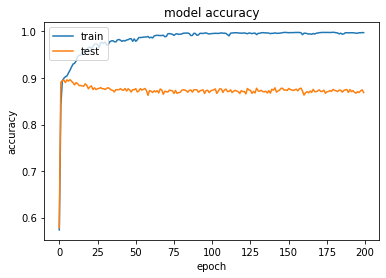

In [32]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


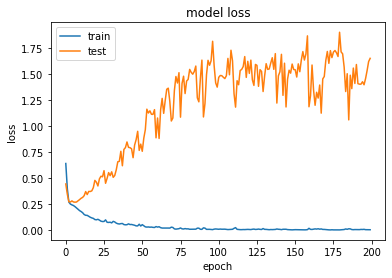

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()